## Import Libraries

In [1]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import matplotlib.image as mpimg
import sklearn
from sklearn.metrics import confusion_matrix 
from scipy.spatial.distance import cdist
from skimage.measure import label, regionprops, moments, moments_central, moments_normalized, moments_hu
from skimage.transform import rescale, resize, downscale_local_mean
from skimage import io, exposure, feature
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle 
import pickle
import cv2
plt.rcParams["figure.figsize"] = (20,3)
import math
import tensorflow.keras.utils as utils
from sklearn.preprocessing import LabelEncoder
from keras import optimizers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense , Activation , Dropout ,Flatten,  MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import cross_val_predict, cross_val_score

Using TensorFlow backend.


## Data PreProcessing Techniques

In [2]:
def face_detection(img):
    # Read image from your local file system
    original_image = img
    # Convert color image to grayscale for Viola-Jones
    grayscale_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    # Load the classifier and create a cascade object for face detection
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_alt.xml')
    detected_faces = face_cascade.detectMultiScale(grayscale_image)
    for (column, row, width, height) in detected_faces:
        cv2.rectangle(
            original_image,
            (column, row),
            (column + width, row + height),
            (0, 255, 0),
            2
        )
        sub_face = img[row:row+height, column:column+width]
    return sub_face

#https://docs.opencv.org/master/d4/d13/tutorial_py_filtering.html
def smoothing(img, d=5, sigmaColor=65, sigmaSpace=65):
    blur_img = cv2.bilateralFilter(img,d,sigmaColor,sigmaSpace)
    return blur_img

#https://docs.opencv.org/3.4/d4/d1b/tutorial_histogram_equalization.html
def histogram_equalization(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    dst = cv2.equalizeHist(img)
    return dst


## Data Download, Preperation and Explorationa, PreProcessing

In [3]:
# get one image function and resize
def get_image(emotion_folders, emotion, img,is_filter=False, filters=None, log_it=False):
    input_img=cv2.imread(emotion_folders + '/'+ emotion + '/'+ img )
    if is_filter and filters == '1':
        input_img = smoothing(input_img)
    elif is_filter and filters == '2':
        input_img = face_detection(input_img)
    elif is_filter and filters == '3':
        input_img = histogram_equalization(input_img)
    input_img_resize=cv2.resize(input_img,(100,100))
    if log_it:
        print ('Loaded image for emotion: '+str(emotion))
    return input_img_resize

# get one image function and resize
def get_all_images(path, all_emotions_folders,is_filter=False, filters=None, log_it=False):
    emotions_list = os.listdir(path)
    indicies = []
    
    emos = []
    num_emos = []
    img_labels = []
    img_all_data=[]
    log_it=True
    for emotion in emotions_list:
        if emotion !='.DS_Store' and emotion!='.ipynb_checkpoints':
            img_list=os.listdir(path+'/'+ emotion) 
            if '.ipynb_checkpoints' in img_list: img_list.remove('.ipynb_checkpoints')
            emos.append(emotion)
            num_emos.append(len(img_list))
            print ('Loaded images for emotion: '+str(emotion)+', number of emotions: '+str(len(img_list)))
            for img in img_list:
                input_img_resize=get_image(path, emotion,img, is_filter, filters, log_it)
                if log_it:
                    indicies.append(len(img_all_data))
                img_all_data.append(input_img_resize)
                img_labels.append(emotion)
                log_it=False
            log_it=True
    img_data = np.array(img_all_data)
    img_labels = np.array(img_labels)
    # why to divide by 255 The reason is that if the color intensity is a float
    #, then matplotlib expects it to range from 0 to 1. If an int, 
    #then it expects 0 to 255. So you can either force all the numbers to int or scale them all by 1/255.
    #https://stackoverflow.com/questions/49643907/clipping-input-data-to-the-valid-range-for-imshow-with-rgb-data-0-1-for-floa
    img_data = img_data.astype('float32')/255
    return img_data,img_labels, indicies
def standarize(data_list):
    stand = []
    for i in data_list:
        standi = (i-i.mean())/i.std()
        stand.append(standi)
    return np.array(stand).astype('float32')

One image Show
Loaded image for emotion: anger
(100, 100, 3)


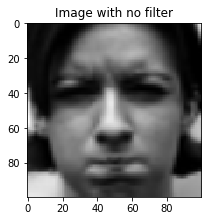

One image with face detection
Loaded image for emotion: anger
(100, 100, 3)


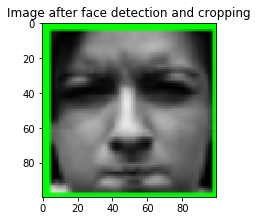

One image with smoothing
Loaded image for emotion: anger
(100, 100, 3)


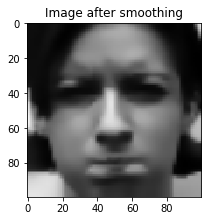

One image with histogram equalization
Loaded image for emotion: anger
(100, 100)


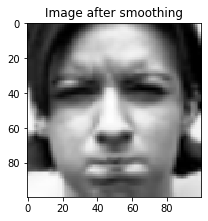

In [4]:
import os, cv2
path = 'archive/CK+48'

all_emotions_folders = os.listdir(path)
if '.DS_Store' in all_emotions_folders: all_emotions_folders.remove('.DS_Store')
if '.ipynb_checkpoints' in all_emotions_folders: all_emotions_folders.remove('.ipynb_checkpoints')

print("One image Show")
img_list=os.listdir(path+'/'+ all_emotions_folders[0])
first_image = get_image(path, all_emotions_folders[0], img_list[0], is_filter=False, filters=None, log_it=True)
print(first_image.shape)
io.imshow(first_image) 
plt.title('Image with no filter') 
io.show()

print("One image with face detection")
first_image = get_image(path, all_emotions_folders[0], img_list[0], is_filter=True, filters='2', log_it=True)
print(first_image.shape)
io.imshow(first_image) 
plt.title('Image after face detection and cropping') 
io.show()

print("One image with smoothing")
first_image = get_image(path, all_emotions_folders[0], img_list[0], is_filter=True, filters='1', log_it=True)
print(first_image.shape)
io.imshow(first_image) 
plt.title('Image after smoothing') 
io.show()

print("One image with histogram equalization")
first_image = get_image(path, all_emotions_folders[0], img_list[0], is_filter=True, filters='3', log_it=True)
print(first_image.shape)
io.imshow(first_image) 
plt.title('Image after smoothing') 
io.show()

In [5]:
from skimage.filters import gabor

In [6]:
img_data, img_labels, indicies = get_all_images(path, all_emotions_folders, is_filter=False, filters='2', log_it=True)

Loaded images for emotion: anger, number of emotions: 135
Loaded image for emotion: anger
Loaded images for emotion: contempt, number of emotions: 54
Loaded image for emotion: contempt
Loaded images for emotion: disgust, number of emotions: 177
Loaded image for emotion: disgust
Loaded images for emotion: fear, number of emotions: 75
Loaded image for emotion: fear
Loaded images for emotion: happy, number of emotions: 207
Loaded image for emotion: happy
Loaded images for emotion: sadness, number of emotions: 84
Loaded image for emotion: sadness
Loaded images for emotion: surprise, number of emotions: 249
Loaded image for emotion: surprise


In [7]:
imgs_features=[]
for img in img_data:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    temp=[]
    for i in range(0,len(gray)):
        temp2=[]
        for j in range(0,len(gray[0])):
            temp2.append([gray[i][j]])
        temp.append(temp2)
    imgs_features.append(temp)
imgs_features=np.asarray(imgs_features)

In [8]:
imgs_features.shape

(981, 100, 100, 1)

## Train and Test Dataset Split

In [9]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(img_labels)
print(set(labels_encoded))
labels_final = utils.to_categorical(labels_encoded, 7)
features_shuffled, labels_shuffled = sklearn.utils.shuffle(imgs_features, labels_final)

{0, 1, 2, 3, 4, 5, 6}


In [10]:
train_len = int(.8 * features_shuffled.shape[0])
all_len = int(len(features_shuffled))
train_ifeatures = features_shuffled[:train_len, :, :, :]
train_labels = labels_shuffled[:train_len]
test_ifeatures = features_shuffled[train_len:, :, :, :]
test_labels = labels_shuffled[train_len:]


print(train_ifeatures.shape)
print(test_ifeatures.shape)
print(test_labels[1])

(784, 100, 100, 1)
(197, 100, 100, 1)
[0. 0. 1. 0. 0. 0. 0.]


In [14]:
def create_model(optim):
    input_shape=(100,100,1)
    model = Sequential()
    model.add(Conv2D(20, (5, 5), input_shape=input_shape, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))  
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(40, (5, 5), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))  
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))
    
    model.add(Conv2D(60, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))
    
    model.add(Conv2D(30, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Flatten())
    model.add(Dense(100))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Dense(7, activation = 'softmax'))

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=optim)
    
    return model

In [17]:
optimizer = tf.keras.optimizers.SGD(lr=0.1, decay=0.01)

model = create_model(optimizer)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 100, 100, 20)      520       
_________________________________________________________________
batch_normalization_10 (Batc (None, 100, 100, 20)      80        
_________________________________________________________________
activation_10 (Activation)   (None, 100, 100, 20)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 50, 50, 20)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 50, 50, 40)        20040     
_________________________________________________________________
batch_normalization_11 (Batc (None, 50, 50, 40)        160       
_________________________________________________________________
activation_11 (Activation)   (None, 50, 50, 40)       

In [18]:
early_stopping = EarlyStopping(

    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

callbacks = [
    early_stopping
]
history = model.fit(x=train_ifeatures, y= train_labels, validation_split=0.1, batch_size=32, 
          epochs=5, shuffle=True, verbose=2 
         )

Epoch 1/5
23/23 - 2s - loss: 0.9688 - accuracy: 0.6780 - val_loss: 1.8739 - val_accuracy: 0.1899
Epoch 2/5
23/23 - 2s - loss: 0.2729 - accuracy: 0.9319 - val_loss: 1.8736 - val_accuracy: 0.1899
Epoch 3/5
23/23 - 2s - loss: 0.1199 - accuracy: 0.9830 - val_loss: 1.9315 - val_accuracy: 0.2025
Epoch 4/5
23/23 - 2s - loss: 0.0644 - accuracy: 0.9943 - val_loss: 2.1253 - val_accuracy: 0.1646
Epoch 5/5
23/23 - 2s - loss: 0.0491 - accuracy: 0.9986 - val_loss: 2.1902 - val_accuracy: 0.1519
